In [2]:
import math
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import glob
import datetime
import copy
from random import shuffle
import random

In [3]:
#could have other hyperparameters in main
def setup(stocks, numBins):
    dates = set()
    filenames = []
    for filename in os.listdir("./Stocks"):
        if len(stocks) == 0:
            if "csv" in filename:
                filenames.append(filename)
        else:
            if "csv" in filename and filename[:-4] in stocks:
                filenames.append(filename)
    #format for consolidate info is {name: {dates: {date, open}, }}
    Histories = {}
    Elos = {}
    for file in filenames:
        with open("Stocks/"+file, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # gets the first line
            previousClose = next(reader)[4]
            #print(file)
            #print(previousClose)
            #return
            history = {}
            for row in reader:
                dates.add(row[0])
                history[row[0]] = (float(row[4])-float(previousClose))/float(previousClose)*100
                previousClose = row[4]
                #print(row)
            Histories[file[:-4]] = history
            Elos[file[:-4]] = {"NumWins":[0]*(numBins+3),"NumLoss":[0]*(numBins+3), "Elos":[1200]*(numBins+3)}
    sortedDates = [date for date in dates]
    sortedDates = sorted(sortedDates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    return Histories,Elos, sortedDates


In [4]:
a, b, c = setup([],10)
print(b)

{'NKE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GOOG': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'HMC': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'AAPL': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1

In [5]:
def getBin(percent, numBins):
    binWidth = 6/(numBins-3)
    for i in range(numBins-1):
        if percent < -3-binWidth/2+i*binWidth:
            return i
    return numBins-1

In [6]:
#one bin means no seperation
#two bins means seperation based on up/down
#n bins partitions [-3,3] into n-2 different equal sections with a bin for [-inf,-3] and [3,inf]
#returns an ordered pair representing the bin
def get2DBin(percents, numBins):
    #hardCode 1 bin and 2 bins
    if numBins == 1:
        return (0,0)
    elif numBins == 2:
        return (int(percents[0] >0), int(percents[1]> 0))
    else:
        daily = 0
        weekly = 0
        binWidth = 6/(numBins-2)
        binHeight = 12/(numBins-2)
        for i in range(numBins-1):
            if percents[0] > -3+binWidth*i:
                daily = i+1
            if percents[1] > -6+binHeight*i:
                weekly = i+1
    return daily, weekly

In [7]:
#result is the current stocks change in percent - the ops stock change in percent
def upDateElo(currentElo, opsElo, result, flexibility):
    variationFromResult = result-(currentElo-opsElo)
    return currentElo + flexibility*variationFromResult

In [8]:
print(get2DBin((0,0),1))
print(get2DBin((0,0),2))
print(get2DBin((5,0),2))
print(get2DBin((.5,.5),3))
print(get2DBin((.5,.5),4))
print(get2DBin((1.1,2.1),8))

(0, 0)
(0, 0)
(1, 0)
(1, 1)
(2, 2)
(5, 5)


In [9]:
def variance(matchesLost, matchesWon):
    return max(1000/((10+matchesLost)*(10+matchesWon)), 1)
def upDateElo(currentElo, opsElo,matchWon, matchesWon, matchesLost):
    newElo = 0
    deltaElo = currentElo-opsElo
    if matchWon:
        differenceMultiplier = (-deltaElo+150)/150 if deltaElo < 0 else 1/((deltaElo+150)/150)
        newElo = currentElo + 8*variance(matchesLost, matchesWon)*differenceMultiplier
        newElo = min(currentElo+150,newElo)
    else:
        differenceMultiplier = (differenceInTeamElos+150)/150 if differenceInTeamElos > 0 else 1/((-differenceInTeamElos+150)/150)
        newElo = currentElo - 8*variance(matchesLost, matchesWon)*differenceMultiplier
        newElo = max(currentElo-150,newElo)
    #print(newElo)
    return newElo

In [10]:
histories, elos, dates = setup([], 10)
print(elos)

{'NKE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GE': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'GOOG': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'HMC': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]}, 'AAPL': {'NumWins': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'NumLoss': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Elos': [1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1

In [11]:
#maybe other hyperparameters
#histories, elos, dates = setup([], 10)
def train(histories,elos,dates):
    companies = list(histories.keys())
    #print(companies)
    #print(info)
    trainingNumber = int(len(dates)*4/5)
    previousDate = dates[0]
    for i in range(1, trainingNumber):
        shuffle(companies)
        currentDate = dates[i]
        for j in range(len(companies)):
            bins = len(elos[companies[j]]["Elos"])
            if previousDate not in histories[companies[j]]:
                continue
            val1 = float(histories[companies[j]][previousDate])
            Bin1 = getBin(val1,bins)
            for k in range(j+1, len(companies)):
                if previousDate not in info[companies[k]]["History"]:
                    continue
                val2 = float(histories[companies[k]][previousDate])
                Bin2 = getBin(val2,bins)
                #if previous dates had change in the same bin
                if Bin1 == Bin2:
                    #check how the next day works
                    val1 = float(histories[companies[j]][currentDate])
                    val2 = float(histories[companies[k]][currentDate])
                    #if j beats k update elos and matches won/lost
                    if val1 > val2:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    True, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumWins"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    False, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumLoss"][Bin1] +=1
                    #if k beats j
                    else:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    False, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumLoss"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    True, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumWins"][Bin1] +=1
        previousDate = currentDate
for key in info:
    print (key)
    print(info[key]["Elos"])
    print(info[key]["NumWins"])
    print(info[key]["NumLoss"])

NameError: name 'info' is not defined

In [12]:
#now lets test this data

In [13]:
profits = [0]
currentProfit = 0
currentInfo = copy.deepcopy(info)
for i in range(trainingNumber, len(dates)):
    shuffle(companies)
    currentDate = dates[i]
    for j in range(len(companies)):
        if previousDate not in currentInfo[companies[j]]["History"]:
            continue
        val1 = float(currentInfo[companies[j]]["History"][previousDate])
        Bin1 = getBin(val1,len(currentInfo[companies[j]]["Elos"]))
        for k in range(j+1, len(companies)):
            if previousDate not in currentInfo[companies[k]]["History"]:
                continue
            val2 = float(currentInfo[companies[k]]["History"][previousDate])
            Bin2 = getBin(val2,len(currentInfo[companies[k]]["Elos"]))
            if Bin1 == Bin2:
                val1 = float(currentInfo[companies[j]]["History"][currentDate])
                val2 = float(currentInfo[companies[k]]["History"][currentDate])
                #if j beats k update elos and matches won/lost
                #time to bet on j
                if currentInfo[companies[j]]["Elos"][Bin1] - currentInfo[companies[k]]["Elos"][Bin1] > 50:
                    if val1 > val2:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    True, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumWins"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    False, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumLoss"][Bin1] +=1
                        currentProfit += val1-val2
                        profits.append(currentProfit)
                    #if k beats j
                    else:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    False, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumLoss"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    True, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumWins"][Bin1] +=1
                        currentProfit += val1-val2
                        profits.append(currentProfit)
                #time to bet on k
                if currentInfo[companies[j]]["Elos"][Bin1] - currentInfo[companies[k]]["Elos"][Bin1] < -50:
                    if val1 > val2:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    True, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumWins"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    False, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumLoss"][Bin1] +=1
                        currentProfit += val2-val1
                        profits.append(currentProfit)
                    #if k beats j
                    else:
                        info[companies[j]]["Elos"][Bin1] = upDateElo(info[companies[j]]["Elos"][Bin1],
                                                                    info[companies[k]]["Elos"][Bin1],
                                                                    False, info[companies[j]]["NumWins"][Bin1],
                                                                    info[companies[j]]["NumLoss"][Bin1])
                        info[companies[j]]["NumLoss"][Bin1] +=1
                        info[companies[k]]["Elos"][Bin1] = upDateElo(info[companies[k]]["Elos"][Bin1],
                                                                    info[companies[j]]["Elos"][Bin1],
                                                                    True, info[companies[k]]["NumWins"][Bin1],
                                                                    info[companies[k]]["NumLoss"][Bin1])
                        info[companies[k]]["NumWins"][Bin1] +=1
                        currentProfit += val2-val1
                        profits.append(currentProfit)
    previousDate = currentDate
    currentInfo = copy.deepcopy(info)
print (profits)

NameError: name 'info' is not defined

Text(0, 0.5, 'Profits')

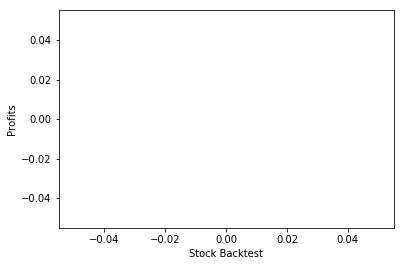

In [14]:
length = len(profits)
timesteps = [i for i in range(length)]
plt.plot(timesteps, profits)
plt.xlabel('Stock Backtest')
plt.ylabel('Profits')

In [15]:
for key in info:
    print (key)
    print(info[key]["Elos"])
    print(info[key]["NumWins"])
    print(info[key]["NumLoss"])

NameError: name 'info' is not defined

In [16]:
#time to play around with elos
def newElos(myElo, opsElo, matchWon):
    newElo = 0
    deltaElo = myElo-opsElo
    if matchWon:
        differenceMultiplier = (-deltaElo+150)/150 if deltaElo < 0 else 1/((deltaElo+150)/150)
        newElo = myElo + 8*differenceMultiplier
        newElo = min(myElo+150,newElo)
    else:
        differenceMultiplier = (deltaElo+150)/150 if deltaElo > 0 else 1/((-deltaElo+150)/150)
        newElo = myElo - 8*differenceMultiplier
        newElo = max(myElo-150,newElo)
    #print(newElo)
    return newElo

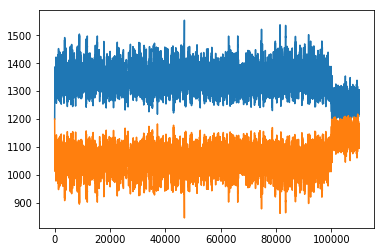

In [17]:
player1 = 1200
player2 = 1200
play1 = [1200]
play2 = [1200]
results = [[1200,1200]]
for i in range(100000):
    play1Wins = True
    newNum = random.randint(1,10)
    if newNum == 1:
        play1Wins = False
    copy = player1
    player1 = newElos(player1,player2,play1Wins)
    player2 = newElos(player2,copy,not play1Wins)
    results.append([player1,player2])
    play1.append(player1)
    play2.append(player2)

for i in range(10000):
    play1Wins = True
    newNum = random.randint(1,4)
    if newNum == 1:
        play1Wins = False
    copy = player1
    player1 = newElos(player1,player2,play1Wins)
    player2 = newElos(player2,copy,not play1Wins)
    results.append([player1,player2])
    play1.append(player1)
    play2.append(player2)


#print(results)
#print(results[-1])
plt.plot(play1)
plt.plot(play2)
plt.show()

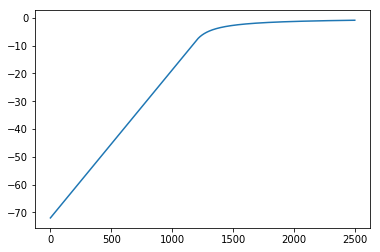

In [18]:
ratings = []
changeInRatings = []
currentRating = 1200
for i in range(2500):
    ratings.append(i)
    newplayer1 = newElos(1200,i,False)
    changeInRatings.append(newplayer1-1200)
    
plt.plot(ratings,changeInRatings)

In [19]:
import pandas as pd
import numpy as np

In [20]:
#clean the data
g = 0
primary = pd.read_csv("SP500Stocks/AAPL.csv")
primary_dates = primary["Date"].values.tolist()
filteredDataFolder = "./SP500Stocks/Filtered/"
for filename in os.listdir("./SP500Stocks"):
    if "csv" in filename:
        df = pd.read_csv("./SP500Stocks/"+filename)
        #print(df["Date"].values[0])
        #print(len(df["Date"].values))
        if df["Date"].values.tolist() != primary_dates:
            g+=1
            print(deletedFileName)
            deletedFileName = filteredDataFolder+filename
            #df.to_csv(deletedFileName, index=False)
            #os.remove("./SP500Stocks/"+filename)
        #if df[]
        #filenames.append(filename)
print(g)

0


In [21]:
aapl = pd.read_csv("SP500Stocks/AAPL.csv")
aapl.head()
aapl.shape

(2413, 7)

In [22]:
def returns(directory, stock):
    df = pd.read_csv(os.path.join(directory, stock), usecols=["Date", "Adj Close"], parse_dates=True)
    df["daily_returns"] = df["Adj Close"].diff().astype("float64")
    df["daily_returns"] = 100 * df["daily_returns"] / df["Adj Close"].shift(1)
    df["5_day_returns"] = df["daily_returns"].rolling(5).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1), raw=False).astype("float64")
    df["Date"] = df["Date"].astype(str)
    df.dropna(inplace=True)
    df.drop(columns="Adj Close", inplace=True)
    df.columns = [stock[:-4] + "_" + col if col != "Date" else col for col in df.columns]
    return df

In [23]:
#merge all stocks together
directory = "SP500Stocks"
files = os.listdir(directory)
master = returns(directory,files[0])

for filename in files[1:]:
    if "csv" in filename:
        master = master.merge(returns(directory,filename), on="Date")
master.head()

,Date,CSCO_daily_returns,CSCO_5_day_returns,UAL_daily_returns,UAL_5_day_returns,TROW_daily_returns,TROW_5_day_returns,ISRG_daily_returns,ISRG_5_day_returns,PRGO_daily_returns,...,LRCX_daily_returns,LRCX_5_day_returns,NWL_daily_returns,NWL_5_day_returns,UAA_daily_returns,UAA_5_day_returns,BLK_daily_returns,BLK_5_day_returns,PPL_daily_returns,PPL_5_day_returns
0,2009-09-18,0.042771,1.342568,-0.930233,11.227154,0.911103,5.895731,1.320038,3.128122,-1.024511,...,3.086259,-1.985040,3.272250,4.434149,1.963486,12.248768,2.351425,2.686235,0.196202,5.728087
1,2009-09-21,0.982905,3.685827,10.328638,11.506524,-1.633727,2.234123,-0.560664,1.594825,1.882043,...,-0.088038,-3.322882,-0.760437,3.026331,3.614865,8.990760,-1.385227,1.535545,-0.228471,3.979568
2,2009-09-22,-0.931012,1.871213,-3.723404,2.957907,3.103170,5.548107,-0.008114,1.248607,0.215547,...,1.997629,1.077154,1.021707,4.698890,-2.999674,4.679803,1.899030,3.752476,0.850537,3.525896
3,2009-09-23,-2.605789,-2.397286,-3.535912,-3.960396,-0.042405,2.365992,-0.681510,-0.926678,-1.075302,...,-0.835252,0.613682,0.189650,1.602571,-4.268908,-1.759227,1.359271,1.966560,-0.778482,-0.130576
4,2009-09-24,-0.657809,-3.163703,1.145475,2.674419,-3.880406,-1.670254,-1.155909,-1.099352,-0.683244,...,-1.306981,2.813961,-2.839156,0.785329,-1.228933,-3.100241,-2.265106,1.887063,-0.163442,-0.130801


In [24]:
print(len(files))

456


In [25]:
master["Date"]

0       2009-09-18
1       2009-09-21
2       2009-09-22
3       2009-09-23
4       2009-09-24
5       2009-09-25
6       2009-09-28
7       2009-09-29
8       2009-09-30
9       2009-10-01
10      2009-10-02
11      2009-10-05
12      2009-10-06
13      2009-10-07
14      2009-10-08
15      2009-10-09
16      2009-10-12
17      2009-10-13
18      2009-10-14
19      2009-10-15
20      2009-10-16
21      2009-10-19
22      2009-10-20
23      2009-10-21
24      2009-10-22
25      2009-10-23
26      2009-10-26
27      2009-10-27
28      2009-10-28
29      2009-10-29
           ...    
1150    2019-03-04
1151    2019-03-05
1152    2019-03-06
1153    2019-03-07
1154    2019-03-08
1155    2019-03-11
1156    2019-03-12
1157    2019-03-13
1158    2019-03-14
1159    2019-03-15
1160    2019-03-18
1161    2019-03-19
1162    2019-03-20
1163    2019-03-21
1164    2019-03-22
1165    2019-03-25
1166    2019-03-26
1167    2019-03-27
1168    2019-03-28
1169    2019-03-29
1170    2019-04-01
1171    2019

In [58]:
#returns a dictionary each stock name is the key and value is 2d array row is 1 day, col is 5 day
def createPlayers(stocks, bins):
    stocks_lower = [stock.lower() for stock in stocks]
    consolidated = {}
    if len(stocks) == 0:
        for filename in os.listdir("./SP500Stocks"):
            if "csv" in filename:
                consolidated[filename[:-4]] = [[0]*bins]*bins
    else:
        for filename in os.listdir("./SP500Stocks"):
            if "csv" in filename and filename[:-4].lower() in stocks_lower:
                consolidated[filename[:-4]] = [[0]*bins]*bins
    return consolidated
#createPlayers([],2)

{'CSCO': [[0, 0], [0, 0]],
 'UAL': [[0, 0], [0, 0]],
 'TROW': [[0, 0], [0, 0]],
 'ISRG': [[0, 0], [0, 0]],
 'PRGO': [[0, 0], [0, 0]],
 'TPR': [[0, 0], [0, 0]],
 'DVN': [[0, 0], [0, 0]],
 'CE': [[0, 0], [0, 0]],
 'MRO': [[0, 0], [0, 0]],
 'BA': [[0, 0], [0, 0]],
 'VRTX': [[0, 0], [0, 0]],
 'GILD': [[0, 0], [0, 0]],
 'EQIX': [[0, 0], [0, 0]],
 'TIF': [[0, 0], [0, 0]],
 'MDT': [[0, 0], [0, 0]],
 'V': [[0, 0], [0, 0]],
 'A': [[0, 0], [0, 0]],
 'FOX': [[0, 0], [0, 0]],
 'MO': [[0, 0], [0, 0]],
 'WCG': [[0, 0], [0, 0]],
 'SWKS': [[0, 0], [0, 0]],
 'MCHP': [[0, 0], [0, 0]],
 'CDNS': [[0, 0], [0, 0]],
 'WLTW': [[0, 0], [0, 0]],
 'MSCI': [[0, 0], [0, 0]],
 'EIX': [[0, 0], [0, 0]],
 'BBY': [[0, 0], [0, 0]],
 'WBA': [[0, 0], [0, 0]],
 'AJG': [[0, 0], [0, 0]],
 'DTE': [[0, 0], [0, 0]],
 'C': [[0, 0], [0, 0]],
 'T': [[0, 0], [0, 0]],
 'CF': [[0, 0], [0, 0]],
 'DISH': [[0, 0], [0, 0]],
 'MGM': [[0, 0], [0, 0]],
 'HUM': [[0, 0], [0, 0]],
 'WU': [[0, 0], [0, 0]],
 'APH': [[0, 0], [0, 0]],
 'SYY': [[0,

In [65]:
##Now for the main script
#lets see our profits if we bet same amount every single time on the favorite
def binary_unweighted_bet_strat(master,stocks, bins, flexibility):
    players = createPlayers(stocks, bins)
    trading_stocks = players.keys()
    #daily profits are the cumulative profits we have each day from all of our trades
    #day profits are profits that we have within each day weighted by how much money we put on
    #since this strat is unweighted for now we will set all the weights to be 1
    daily_profits = [0]
    day_profits = []
    for i in range(master.shape[0]-1):
        for stock_1 in trading_stocks:
            print(stock_1)
            print(master.iloc[i][stock_1+"_daily_returns"])
            print(master.iloc[i][stock_1+"_5_day_returns"])
            numCollisions = 0
            for stock_2 in trading_stocks:
                if stock_1 != stock_2 and get2DBin((master.iloc[i][stock_1+"_daily_returns"],
                             master.iloc[i][stock_1+"_5_day_returns"]), bins) == get2DBin((master.iloc[i][stock_2+"_daily_returns"],
                             master.iloc[i][stock_2+"_5_day_returns"]), bins):
                    print(stock_1)
                    print(stock_2)
                
                #continue
                #print(stock_1)
                #print(master.iloc[i][stock_1+"_daily_returns"])
                #print(master.iloc[i][stock_1+"_5_day_returns"])
        return
        print (i)
binary_unweighted_bet_strat(master, [],5,.01)      

CSCO
0.04277115098304179
1.3425682152793605
CSCO
GILD
CSCO
A
CSCO
MO
CSCO
WCG
CSCO
MCHP
CSCO
WBA
CSCO
AJG
CSCO
DTE
CSCO
HUM
CSCO
SYY
CSCO
UTX
CSCO
HOG
CSCO
LLY
CSCO
COST
CSCO
XRAY
CSCO
SNA
CSCO
UNP
CSCO
IR
CSCO
INTU
CSCO
INTC
CSCO
BDX
CSCO
MMM
CSCO
UPS
CSCO
MSFT
CSCO
WEC
CSCO
EW
CSCO
HPQ
CSCO
AMD
CSCO
BIIB
CSCO
CHRW
CSCO
AON
CSCO
FDX
CSCO
CAG
CSCO
SCHW
CSCO
AXP
CSCO
HRL
CSCO
ZBH
CSCO
XOM
CSCO
PNW
CSCO
UHS
CSCO
ROK
CSCO
FIS
CSCO
CELG
CSCO
VAR
CSCO
ITW
CSCO
CNP
CSCO
RE
CSCO
HRB
CSCO
DIS
CSCO
NTRS
CSCO
CTL
CSCO
ABC
CSCO
ABT
CSCO
JBHT
CSCO
COP
CSCO
DHR
CSCO
MCK
CSCO
RMD
CSCO
ALK
CSCO
HRS
CSCO
FFIV
CSCO
SNPS
CSCO
KSS
CSCO
VFC
CSCO
NKTR
CSCO
JKHY
CSCO
ANTM
CSCO
GPS
CSCO
GIS
CSCO
ROST
CSCO
K
CSCO
KSU
CSCO
TTWO
CSCO
AES
CSCO
TGT
CSCO
GRMN
CSCO
DLTR
CSCO
HAS
CSCO
WMT
CSCO
NTAP
CSCO
BMY
CSCO
PKG
CSCO
WAB
CSCO
JNJ
CSCO
CRM
CSCO
PGR
CSCO
WAT
UAL
-0.9302325581395358
11.227154046997345
UAL
DVN
UAL
MGM
UAL
STI
UAL
LNT
UAL
NOV
UAL
ARE
UAL
BXP
UAL
ECL
UAL
CAT
UAL
AMZN
UAL
RL
UAL
EXPE
UAL
FLIR
UAL
FL
UA

A
HAS
A
WMT
A
NTAP
A
BMY
A
PKG
A
WAB
A
JNJ
A
CRM
A
PGR
A
WAT
FOX
0.4912272679435254
4.449300876107798
FOX
TROW
FOX
BA
FOX
TIF
FOX
V
FOX
WLTW
FOX
CF
FOX
WU
FOX
APH
FOX
MSI
FOX
PKI
FOX
BAC
FOX
LNC
FOX
GPN
FOX
STZ
FOX
FLS
FOX
DXC
FOX
TDG
FOX
TFX
FOX
FLR
FOX
PEG
FOX
LLL
FOX
MDLZ
FOX
XEL
FOX
FAST
FOX
TJX
FOX
D
FOX
EBAY
FOX
JEC
FOX
MCD
FOX
WELL
FOX
MOS
FOX
JNPR
FOX
DHI
FOX
ES
FOX
KO
FOX
PCAR
FOX
NEE
FOX
EMR
FOX
ANSS
FOX
AME
FOX
SHW
FOX
EA
FOX
IDXX
FOX
ALB
FOX
INCY
FOX
SO
FOX
CVX
FOX
VTR
FOX
MTD
FOX
IBM
FOX
GS
FOX
GD
FOX
CAH
FOX
CBRE
FOX
ETN
FOX
LEN
FOX
FITB
FOX
FE
FOX
JPM
FOX
OMC
FOX
TSCO
FOX
ATO
FOX
TXT
FOX
AKAM
FOX
ROL
FOX
GOOGL
FOX
PAYX
FOX
MMC
FOX
FOXA
FOX
SRE
FOX
ORLY
FOX
GOOG
FOX
DUK
FOX
JCI
FOX
AMGN
FOX
ADP
FOX
RSG
FOX
BLL
FOX
PHM
FOX
LUV
FOX
CHD
FOX
APA
FOX
AFL
FOX
NI
FOX
FISV
FOX
PBCT
FOX
DVA
FOX
HON
FOX
O
FOX
SLB
FOX
XRX
FOX
AEE
FOX
BAX
FOX
LMT
FOX
UNM
FOX
NBL
FOX
CTSH
FOX
SWK
FOX
MU
FOX
L
FOX
FTI
FOX
TSS
FOX
PPL
MO
-0.3329723150426587
-0.9922650406961497
MO
CSCO
MO
GILD
MO
A
MO
WC

CF
TXT
CF
AKAM
CF
ROL
CF
GOOGL
CF
PAYX
CF
MMC
CF
FOXA
CF
SRE
CF
ORLY
CF
GOOG
CF
DUK
CF
JCI
CF
AMGN
CF
ADP
CF
RSG
CF
BLL
CF
PHM
CF
LUV
CF
CHD
CF
APA
CF
AFL
CF
NI
CF
FISV
CF
PBCT
CF
DVA
CF
HON
CF
O
CF
SLB
CF
XRX
CF
AEE
CF
BAX
CF
LMT
CF
UNM
CF
NBL
CF
CTSH
CF
SWK
CF
MU
CF
L
CF
FTI
CF
TSS
CF
PPL
DISH
1.1745069038398113
3.0182291930232585
DISH
ISRG
DISH
CDNS
DISH
EIX
DISH
LOW
DISH
STX
DISH
NOC
DISH
ETR
DISH
EXPD
DISH
CCI
DISH
ED
DISH
CTAS
DISH
RTN
DISH
COO
DISH
KLAC
DISH
HD
DISH
JEF
DISH
CMS
DISH
AMG
DISH
BEN
DISH
DISCK
DISH
SBAC
DISH
USB
DISH
ALL
DISH
GWW
DISH
DISCA
DISH
CINF
DISH
YUM
DISH
STT
DISH
IFF
DISH
GPC
DISH
EFX
DISH
AEP
DISH
DOV
DISH
BLK
MGM
-0.6014980912894548
11.655399243305741
MGM
UAL
MGM
DVN
MGM
STI
MGM
LNT
MGM
NOV
MGM
ARE
MGM
BXP
MGM
ECL
MGM
CAT
MGM
AMZN
MGM
RL
MGM
EXPE
MGM
FLIR
MGM
FL
MGM
AVY
MGM
NDAQ
MGM
URI
MGM
PNC
MGM
EXC
MGM
HIG
MGM
SEE
MGM
FRT
MGM
AMP
MGM
NKE
MGM
MAR
MGM
LKQ
MGM
EOG
MGM
AVB
MGM
GE
MGM
PH
MGM
HFC
MGM
VNO
MGM
RCL
MGM
ARNC
MGM
SIVB
MGM
SLG
MGM
JWN
MGM
ADS
M

BAC
STZ
BAC
FLS
BAC
DXC
BAC
TDG
BAC
TFX
BAC
FLR
BAC
PEG
BAC
LLL
BAC
MDLZ
BAC
XEL
BAC
FAST
BAC
TJX
BAC
D
BAC
EBAY
BAC
JEC
BAC
MCD
BAC
WELL
BAC
MOS
BAC
JNPR
BAC
DHI
BAC
ES
BAC
KO
BAC
PCAR
BAC
NEE
BAC
EMR
BAC
ANSS
BAC
AME
BAC
SHW
BAC
EA
BAC
IDXX
BAC
ALB
BAC
INCY
BAC
SO
BAC
CVX
BAC
VTR
BAC
MTD
BAC
IBM
BAC
GS
BAC
GD
BAC
CAH
BAC
CBRE
BAC
ETN
BAC
LEN
BAC
FITB
BAC
FE
BAC
JPM
BAC
OMC
BAC
TSCO
BAC
ATO
BAC
TXT
BAC
AKAM
BAC
ROL
BAC
GOOGL
BAC
PAYX
BAC
MMC
BAC
FOXA
BAC
SRE
BAC
ORLY
BAC
GOOG
BAC
DUK
BAC
JCI
BAC
AMGN
BAC
ADP
BAC
RSG
BAC
BLL
BAC
PHM
BAC
LUV
BAC
CHD
BAC
APA
BAC
AFL
BAC
NI
BAC
FISV
BAC
PBCT
BAC
DVA
BAC
HON
BAC
O
BAC
SLB
BAC
XRX
BAC
AEE
BAC
BAX
BAC
LMT
BAC
UNM
BAC
NBL
BAC
CTSH
BAC
SWK
BAC
MU
BAC
L
BAC
FTI
BAC
TSS
BAC
PPL
LNC
-0.41636539362711633
5.832642138008559
LNC
TROW
LNC
BA
LNC
TIF
LNC
V
LNC
FOX
LNC
WLTW
LNC
CF
LNC
WU
LNC
APH
LNC
MSI
LNC
PKI
LNC
BAC
LNC
GPN
LNC
STZ
LNC
FLS
LNC
DXC
LNC
TDG
LNC
TFX
LNC
FLR
LNC
PEG
LNC
LLL
LNC
MDLZ
LNC
XEL
LNC
FAST
LNC
TJX
LNC
D
LNC
EBAY
LNC
JEC
LNC
MCD

TDG
WLTW
TDG
CF
TDG
WU
TDG
APH
TDG
MSI
TDG
PKI
TDG
BAC
TDG
LNC
TDG
GPN
TDG
STZ
TDG
FLS
TDG
DXC
TDG
TFX
TDG
FLR
TDG
PEG
TDG
LLL
TDG
MDLZ
TDG
XEL
TDG
FAST
TDG
TJX
TDG
D
TDG
EBAY
TDG
JEC
TDG
MCD
TDG
WELL
TDG
MOS
TDG
JNPR
TDG
DHI
TDG
ES
TDG
KO
TDG
PCAR
TDG
NEE
TDG
EMR
TDG
ANSS
TDG
AME
TDG
SHW
TDG
EA
TDG
IDXX
TDG
ALB
TDG
INCY
TDG
SO
TDG
CVX
TDG
VTR
TDG
MTD
TDG
IBM
TDG
GS
TDG
GD
TDG
CAH
TDG
CBRE
TDG
ETN
TDG
LEN
TDG
FITB
TDG
FE
TDG
JPM
TDG
OMC
TDG
TSCO
TDG
ATO
TDG
TXT
TDG
AKAM
TDG
ROL
TDG
GOOGL
TDG
PAYX
TDG
MMC
TDG
FOXA
TDG
SRE
TDG
ORLY
TDG
GOOG
TDG
DUK
TDG
JCI
TDG
AMGN
TDG
ADP
TDG
RSG
TDG
BLL
TDG
PHM
TDG
LUV
TDG
CHD
TDG
APA
TDG
AFL
TDG
NI
TDG
FISV
TDG
PBCT
TDG
DVA
TDG
HON
TDG
O
TDG
SLB
TDG
XRX
TDG
AEE
TDG
BAX
TDG
LMT
TDG
UNM
TDG
NBL
TDG
CTSH
TDG
SWK
TDG
MU
TDG
L
TDG
FTI
TDG
TSS
TDG
PPL
TFX
0.3486517562405004
5.840335853895695
TFX
TROW
TFX
BA
TFX
TIF
TFX
V
TFX
FOX
TFX
WLTW
TFX
CF
TFX
WU
TFX
APH
TFX
MSI
TFX
PKI
TFX
BAC
TFX
LNC
TFX
GPN
TFX
STZ
TFX
FLS
TFX
DXC
TFX
TDG
TFX
FLR
TFX
PEG
TFX
LLL
TFX

MDLZ
INCY
MDLZ
SO
MDLZ
CVX
MDLZ
VTR
MDLZ
MTD
MDLZ
IBM
MDLZ
GS
MDLZ
GD
MDLZ
CAH
MDLZ
CBRE
MDLZ
ETN
MDLZ
LEN
MDLZ
FITB
MDLZ
FE
MDLZ
JPM
MDLZ
OMC
MDLZ
TSCO
MDLZ
ATO
MDLZ
TXT
MDLZ
AKAM
MDLZ
ROL
MDLZ
GOOGL
MDLZ
PAYX
MDLZ
MMC
MDLZ
FOXA
MDLZ
SRE
MDLZ
ORLY
MDLZ
GOOG
MDLZ
DUK
MDLZ
JCI
MDLZ
AMGN
MDLZ
ADP
MDLZ
RSG
MDLZ
BLL
MDLZ
PHM
MDLZ
LUV
MDLZ
CHD
MDLZ
APA
MDLZ
AFL
MDLZ
NI
MDLZ
FISV
MDLZ
PBCT
MDLZ
DVA
MDLZ
HON
MDLZ
O
MDLZ
SLB
MDLZ
XRX
MDLZ
AEE
MDLZ
BAX
MDLZ
LMT
MDLZ
UNM
MDLZ
NBL
MDLZ
CTSH
MDLZ
SWK
MDLZ
MU
MDLZ
L
MDLZ
FTI
MDLZ
TSS
MDLZ
PPL
BKNG
-1.3373499999999978
0.5402118062693084
BKNG
CE
BKNG
MDT
BKNG
FCX
BKNG
IRM
BKNG
CPRT
BKNG
CB
BKNG
MET
BKNG
PNR
BKNG
OXY
BKNG
HP
BKNG
ACN
BKNG
CCL
BKNG
ATVI
BKNG
HSIC
BKNG
CVS
BKNG
AOS
BKNG
COF
BKNG
COG
BKNG
IVZ
BKNG
ALXN
BKNG
PFG
BKNG
UNH
BKNG
WMB
BKNG
CI
FMC
1.772548729720761
7.668025973126458
FMC
TPR
FMC
ESS
FMC
HAL
FMC
REG
FMC
HCP
FMC
AIZ
FMC
IPG
FMC
AMT
FMC
CMA
FMC
MNST
FMC
DWDP
FMC
UDR
FMC
CMG
FMC
SPG
FMC
MYL
FMC
WHR
FMC
KMX
FMC
ICE
FMC
PLD
FMC
CBS
FM

BXP
NOV
BXP
ARE
BXP
ECL
BXP
CAT
BXP
AMZN
BXP
RL
BXP
EXPE
BXP
FLIR
BXP
FL
BXP
AVY
BXP
NDAQ
BXP
URI
BXP
PNC
BXP
EXC
BXP
HIG
BXP
SEE
BXP
FRT
BXP
AMP
BXP
NKE
BXP
MAR
BXP
LKQ
BXP
EOG
BXP
AVB
BXP
GE
BXP
PH
BXP
HFC
BXP
VNO
BXP
RCL
BXP
ARNC
BXP
SIVB
BXP
SLG
BXP
JWN
BXP
ADS
BXP
ZION
BXP
EQR
BXP
AAPL
BXP
APD
BXP
PSA
BXP
WYNN
BXP
NUE
BXP
VIAB
IPG
2.60988620302108
10.666679402093738
IPG
TPR
IPG
ESS
IPG
HAL
IPG
REG
IPG
FMC
IPG
HCP
IPG
AIZ
IPG
AMT
IPG
CMA
IPG
MNST
IPG
DWDP
IPG
UDR
IPG
CMG
IPG
SPG
IPG
MYL
IPG
WHR
IPG
KMX
IPG
ICE
IPG
PLD
IPG
CBS
IPG
NFLX
IPG
MAC
IPG
MTB
IPG
DRI
IPG
ILMN
IPG
AIV
IPG
LB
IPG
MS
IPG
OKE
IPG
MHK
IPG
AIG
IPG
MA
IPG
WY
IPG
BBT
IPG
KEY
IPG
M
IPG
UAA
UNP
0.08018989774857983
-0.23981326267905612
UNP
CSCO
UNP
GILD
UNP
A
UNP
MO
UNP
WCG
UNP
MCHP
UNP
WBA
UNP
AJG
UNP
DTE
UNP
HUM
UNP
SYY
UNP
UTX
UNP
HOG
UNP
LLY
UNP
COST
UNP
XRAY
UNP
SNA
UNP
IR
UNP
INTU
UNP
INTC
UNP
BDX
UNP
MMM
UNP
UPS
UNP
MSFT
UNP
WEC
UNP
EW
UNP
HPQ
UNP
AMD
UNP
BIIB
UNP
CHRW
UNP
AON
UNP
FDX
UNP
CAG
UNP
SCHW
UNP
AXP
U

KeyboardInterrupt: 

In [1]:
a = master.values
a_new = []
for row in a:
    row_new = []
    print(row[0])
    exit()
    for index in range(1,len(row),2):
        row_new.append((row[index],row[index+1]))
    a_new.append(row)
a_new

NameError: name 'master' is not defined